In [240]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jun 30 10:41:49 2019

@author: sahil
"""

import pandas as pd
import numpy as np
import pandas_datareader.data as web

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.linear_model import LinearRegression


# Get the data
def get_data():
	return_period = 21

	stk_tickers = ['MSFT', 'IBM', 'GOOGL']
	ccy_tickers = ['DEXJPUS', 'DEXUSUK']
	idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

	stk_data = web.DataReader(stk_tickers, 'yahoo')
	ccy_data = web.DataReader(ccy_tickers, 'fred')
	idx_data = web.DataReader(idx_tickers, 'fred')

	Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
	Y.name = Y.name[-1]+'_pred'

	X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
	X1.columns = X1.columns.droplevel()
	X2 = np.log(ccy_data).diff(return_period)
	X3 = np.log(idx_data).diff(return_period)

	X4 = pd.concat([Y.diff(i) for i in [21, 63, 126,252]], axis=1).dropna()
	X4.columns = ['1M', '3M', '6M', '1Y']

	X = pd.concat([X1, X2, X3, X4], axis=1)

	data = pd.concat([Y, X], axis=1).dropna()
	Y = data.loc[:, Y.name]
	X = data.loc[:, X.columns]
	return X, Y

X, Y= get_data()

In [241]:
dataset = pd.concat([Y, X], axis=1).dropna()

In [242]:
dataset.head(5)
dataset.shape

(2006, 12)

Convert the data to the version compatible with supervised learning, where all the dependent variables are lagged along with other IVs.
Function to be used as follows:
- data: Sequence of observations as a list or 2D NumPy array. Required.
- n_in: Number of lag observations as input (X). Values may be between [1..len(data)] Optional. Defaults to 1.
- n_out: Number of observations as output (y). Values may be between [0..len(data)-1]. Optional. Defaults to 1.
- dropnan: Boolean whether or not to drop rows with NaN values. Optional. Defaults to True.

In [243]:
# convert series to the data compatible for supervised learning problem
#The return of the stock 
#Keep the name intact
def series_to_supervised(data, lag=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)    
    cols, names = list(), list()
    for i in range(lag, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg = pd.DataFrame(data.iloc[:,0]).join(agg)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [244]:
reframed= series_to_supervised(dataset,1)

In [245]:
#Drop Column that are not needed all the columns related to the current time period of the IVs
#reframed=reframed.iloc[:,0:int(reframed.shape[1]/2+1)]
reframed.head(5)

,MSFT_pred,MSFT_pred(t-1),GOOGL(t-1),IBM(t-1),DEXJPUS(t-1),DEXUSUK(t-1),SP500(t-1),DJIA(t-1),VIXCLS(t-1),1M(t-1),3M(t-1),6M(t-1),1Y(t-1)
2011-01-04,-0.015788,-0.001430,0.055329,0.015719,-0.014243,-0.014930,0.037784,0.025045,-0.022460,-0.041166,-0.137312,-0.078562,0.076488
2011-01-05,-0.008248,-0.015788,0.049571,0.015426,-0.008988,-0.006013,0.037769,0.028544,-0.036162,-0.054624,-0.120203,-0.058879,0.090435
2011-01-06,-0.021747,-0.008248,0.051737,0.014108,0.002165,-0.019490,0.042249,0.031519,-0.055427,-0.050560,-0.113445,-0.053893,0.085373
2011-01-07,-0.011252,-0.021747,0.043917,0.031710,-0.012074,-0.019309,0.036429,0.028162,-0.019352,-0.091807,-0.112116,-0.075489,0.072184
2011-01-10,-0.008898,-0.011252,0.042924,0.020143,-0.009707,-0.011057,0.030747,0.026446,-0.006397,-0.060340,-0.098501,-0.020871,0.079145


In [246]:
Y= np.array(reframed["MSFT_pred"])
X = np.array(reframed.loc[:, reframed.columns != 'MSFT_pred'])

In [247]:
# split out validation dataset for the end
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler().fit(X)
# StandardisedX = pd.DataFrame(scaler.fit_transform(X))
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [248]:
X_train= X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_validation= X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))
print(X_train.shape, Y_train.shape, X_validation.shape, Y_validation.shape)

(1604, 1, 12) (1604,) (401, 1, 12) (401,)


In [249]:
X_train

array([[[-0.00540012,  0.06675433,  0.01397417, ...,  0.00807343,
         -0.03000404,  0.0606205 ]],

       [[ 0.04305776,  0.06377137, -0.03087694, ...,  0.0694208 ,
          0.10786274,  0.01224553]],

       [[ 0.06508718, -0.02935815,  0.00292757, ...,  0.04750487,
          0.11596184,  0.05083729]],

       ...,

       [[ 0.07566343, -0.05495538,  0.00909798, ...,  0.04853943,
          0.08134031,  0.1036531 ]],

       [[ 0.02460392, -0.00218574,  0.04347873, ..., -0.02506848,
          0.09062454,  0.05350333]],

       [[ 0.08047208,  0.00354015,  0.02583158, ..., -0.04454768,
          0.0882513 ,  0.04232268]]])

In [250]:
# design network
from matplotlib import pyplot
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, Y_train, epochs=50, batch_size=72, validation_data=(X_validation, Y_validation), verbose=1, shuffle=False)
# plot history


Train on 1604 samples, validate on 401 samples
Epoch 1/50
1604/1604 [==============================] - 1s 479us/step - loss: 0.0415 - val_loss: 0.0357
Epoch 2/50
1604/1604 [==============================] - 0s 25us/step - loss: 0.0307 - val_loss: 0.0257
Epoch 3/50
1604/1604 [==============================] - 0s 25us/step - loss: 0.0233 - val_loss: 0.0205
Epoch 4/50
1604/1604 [==============================] - 0s 22us/step - loss: 0.0211 - val_loss: 0.0196
Epoch 5/50
1604/1604 [==============================] - 0s 25us/step - loss: 0.0205 - val_loss: 0.0193
Epoch 6/50
1604/1604 [==============================] - 0s 25us/step - loss: 0.0199 - val_loss: 0.0189
Epoch 7/50
1604/1604 [==============================] - 0s 22us/step - loss: 0.0194 - val_loss: 0.0186
Epoch 8/50
1604/1604 [==============================] - 0s 22us/step - loss: 0.0190 - val_loss: 0.0182
Epoch 9/50
1604/1604 [==============================] - 0s 22us/step - loss: 0.0186 - val_loss: 0.0179
Epoch 10/50
1604/1604 [==

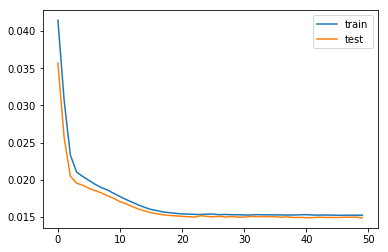

In [251]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [252]:
# make a prediction
predictions = model.predict(X_validation)
predictions.shape

(401, 1)

In [253]:
Y_validation = Y_validation.reshape((len(Y_validation), 1))
#Y_validation.shape

In [254]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

0.0004356925211400366
0.8550426566147347


In [255]:
X.shape

(2005, 12)

In [256]:
reframed.iloc[:,-1]

2011-01-04    0.076488
2011-01-05    0.090435
2011-01-06    0.085373
2011-01-07    0.072184
2011-01-10    0.079145
2011-01-11    0.069411
2011-01-12    0.045107
2011-01-13    0.036491
2011-01-14    0.048756
2011-01-18    0.029124
2011-01-19    0.013250
2011-01-20    0.017302
2011-01-21   -0.001753
2011-01-25   -0.029161
2011-01-26   -0.028655
2011-01-27   -0.045138
2011-01-28   -0.076604
2011-02-01   -0.067663
2011-02-02   -0.070815
2011-02-03   -0.071262
2011-02-04   -0.099111
2011-02-07   -0.095556
2011-02-08   -0.128344
2011-02-09   -0.146706
2011-02-10   -0.128908
2011-02-11   -0.107621
2011-02-14   -0.119743
2011-02-16   -0.132146
2011-02-17   -0.106909
2011-02-18   -0.100036
                ...   
2019-04-30   -0.081137
2019-05-01   -0.061231
2019-05-02   -0.090464
2019-05-03   -0.092045
2019-05-06   -0.121153
2019-05-07   -0.096593
2019-05-08   -0.053747
2019-05-09   -0.017898
2019-05-10    0.002837
2019-05-13   -0.009528
2019-05-14    0.031708
2019-05-15    0.022158
2019-05-16 